In [6]:
from ipywidgets import widgets
from ipywidgets import Layout
from IPython import display

import numpy as np
import serial
import time
import sys
import glob
import io

ramps=False

def serial_ports():
    if sys.platform.startswith('win'):
        ports = ['COM%s' % (i + 1) for i in range(256)]
    elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
        # this excludes your current terminal "/dev/tty"
        ports = glob.glob('/dev/tty[A-Za-z]*')
    elif sys.platform.startswith('darwin'):
        ports = glob.glob('/dev/tty.*')
    else:
        raise EnvironmentError('Unsupported platform')

    result = []
    for port in ports:
        try:
            s = serial.Serial(port)
            s.close()
            result.append(port)
        except (OSError, serial.SerialException):
            pass
    return result

def send_printer_ramps(cmd='', show=False):
    global ser_p

    ser_p.write(cmd)
    out=ser_p.readline()
    if out != '':
        if show:
            print(out)
    return out

def send_printer_marlin(cmd='', show=False):
    global ser_p
    
    if not cmd == '':
        ser_p.flushInput()
        ser_p.write(cmd)
        out = ser_p.readline().strip();
    if show:
        print(out)
    return out

def printer_init_marlin():
    global ser_p
    ser_p.write(b'G0\n')
    out=ser_p.readline().strip()
    while (out != b'ok'):
        ser_p.write(b'G0\n')
        out=ser_p.readline().strip()
    
def print_parser(cmdlines):
    for line in cmdlines.split(';'):
        if not (line== ''):
            out=(line+'\n').encode()
            if ramps:
                send_printer_ramps(out)
            else:
                send_printer_marlin(out)

def read_scale(n):
    ser_s.flushInput()
    res=[ser_s.readline() for i in range(n)]
    return [float(res[i].decode()) for i in range(len(res))]

def read_scale_times(t_s=1.):
    res=[]
    res_t=[]
    ser_s.flushInput()
    start = time.time()

    while (time.time()-start<=t_s):
        res.append(ser_s.readline())
        res_t.append(time.time()-start)
    res=[float(res[i].decode()) for i in range(len(res))]
    
    return res,res_t
    

In [5]:
print('checking for serial ports')
sports=serial_ports()
print(sports)

checking for serial ports
['/dev/tty.Bluetooth-Incoming-Port', '/dev/tty.usbserial-AK06SAI5', '/dev/tty.wchusbserial1420']


In [9]:
def my_connect(newvalue):
    global ser_s, ser_p
    if (w_connect.value=='connect'):
        try:
            ser_s = serial.Serial(w_pscale.value, baudrate=115200, timeout=5) #scale
            ser_p = serial.Serial(w_pzaxis.value, baudrate=115200, timeout=5) #printer
            time.sleep(1)
            connected = True
        except:
            w_connect.value='disconnect'
            connected=False
            ser_s.close()
            ser_p.close()
            print("ERROR: couldn't open serial port.")
            time.sleep(1)
            #reread serial ports
            myserialports=serial_ports()
            w_pscale.options=myserialports
            w_pzaxis.options=myserialports
            w_pscale.value=myserialports[-1]
            w_pzaxis.value=myserialports[-2]

    else:
        ser_p.close()
        ser_s.close()
        connected = False

try:
    myserialports
except NameError:
    myserialports=serial_ports()
        
w_connect=widgets.ToggleButtons(description='Devices:',\
                               options=['connect', 'disconnect'], value="disconnect")
w_pscale=widgets.Dropdown(options=myserialports,\
                         value=myserialports[-1], description='Scale:', disabled=False)
w_pzaxis=widgets.Dropdown(options=myserialports,\
                         value=myserialports[-2], description='Zaxis:', disabled=False)
w_connect.observe(my_connect, names='value')
display.display(widgets.HBox([widgets.VBox([w_pscale,w_pzaxis]),w_connect]))

In [14]:
if ~ramps:
    printer_init_marlin()
    send_printer_marlin(b'M203 Z20\r\n') #increase maximum feedrate for z axis
    send_printer_marlin(b'M107\r\n') #fan off 
    send_printer_marlin(b'G91\r\n') #relative positioning

In [18]:
import threading

nn=10
rate=.5 #frequency of up/down
if ramps:
    speed=140.*rate
else:
    speed=288.*rate
deltaz=1.5

if ~ramps:
    send_printer_marlin('G1 F{:d}\r\n'.format(int(speed*deltaz)).encode())
    
#generate G-code to send to printer
cmd=''
for i in range(nn):
    if ramps:
        cmd +='$J=G91 Z{:4.1f}F{:4.0f};'.format(-deltaz, speed)
        cmd +='$J=G91 Z{:4.1f}F{:4.0f};'.format(deltaz, speed)
    else:
        cmd +='G0 Z{:4.1f};'.format(-deltaz)
        cmd +='G0 Z{:4.1f};'.format(deltaz)

ser_s.write(b'*')  #Tare the scale
ser_s.flushOutput()

time.sleep(1) #stabilize the scale

pt = threading.Thread(target=print_parser, args=(cmd,))
pt.start()
    
#%time y,x=read_scale_times(nn*deltaz/rate)
%time y,x=read_scale_times(nn/rate)

ValueError: could not convert string to float: 

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
xnp=np.array(x,dtype=np.float32)
ynp=np.array(y,dtype=np.float32)
peaks, _ = find_peaks(y, height=ynp.max()/2., distance=len(y)/2./nn)
plt.plot(xnp, ynp)
for i in range(len(peaks)):
    plt.text(xnp[peaks[i]], ynp[peaks[i]],str(i))

NameError: name 'x' is not defined

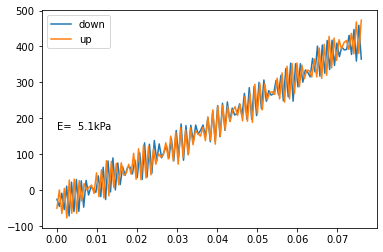

In [112]:
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import numpy as np

peak_i=-17#peak position to analyse
g=9.81    #gravitational acceleration
obj_h=23. #height in mm
obj_A=np.pi*(13e-3)**2 #Area in m2
delta0=2.5 #initial displacement in mm


down_start_index=int(peaks[peak_i-1]+(peaks[peak_i]-peaks[peak_i-1])/2.)#find down start index
down_end_index=peaks[peak_i]
up_start_index=peaks[peak_i-1]
down_stroke=ynp[down_start_index:down_end_index]
up_stroke=ynp[up_start_index:down_start_index-1]
down_pos=np.linspace(0,deltaz,len(down_stroke))
up_pos=deltaz-np.linspace(0,deltaz,len(up_stroke))
### Calculate strain 
max_strain,_ = integrate.quad(lambda xx: -1./xx, obj_h-delta0, obj_h-delta0-down_pos[-1])
down_strain = np.linspace(0.,max_strain,len(down_stroke))
up_strain = np.linspace(max_strain, 0.,len(up_stroke))

up_stress=up_stroke*1e-3*g/obj_A
down_stress=down_stroke*1e-3*g/obj_A

#Simple Expression for Elastic Modulus, better by fitting a line to the center and take the slope 
EM0=(down_stress[-1]-down_stress[0])/max_strain
plt.text(0,(down_stress[-1]-down_stress[0])/2.+down_stress[0],"E={:5.1f}kPa".format(EM0/1e3))
plt.plot(down_strain,down_stress,label='down');
plt.plot(up_strain,up_stress,label='up')
plt.legend();



In [113]:
import pickle

with open('Gelatin15DecTue_4b%.pkl', 'wb') as f: 
    pickle.dump([peak_i, g, obj_h, obj_A, delta0, peaks, x, y, xnp, ynp,\
                 deltaz, nn, rate, speed ], f)


In [3]:
import pickle

with open('PDMS20.pkl', 'rb') as f: 
    peak_i, g, obj_h, obj_A, delta0, peaks, x, y, xnp, ynp,\
                 deltaz, nn, rate, speed = pickle.load(f)

In [2]:
ramps=False
if ~ramps:
    print('False')

False


In [20]:
read_scale(1)

ValueError: could not convert string to float: 